In [1]:
# Import libraries
import os, math
import numpy as np
import rasterio as rio
import rasterio.merge as riomerge
import mercantile as merc
import fiona

# Import specifics
from shapely.geometry import box, Point, MultiPoint
from torch.utils.data import DataLoader

# Import utility functions
from utils import m_to_dd, ChipsDataset

# Import plotting functions
from rasterio.plot import show
from matplotlib import pyplot

In [2]:
'''
Process variables
'''
# Directory of the chip coordinates GeoJSON file
coords_file = './data/coordinates.geojson'

# Directory of the tiled GeoTIFF rasters
raster_dir = './data/rasters/'

# Raster pixel size in metres
pix_m = 30

# Chip size (pixel padding used to create clipping window)
chip_size = 9

# Satellite image variables
obs_years = 37
bands_per_year = 6

In [3]:
'''
Get the chip coordinates from input file
'''

# Set empty coordinates container
coords = []

# Read the coordinate features from disk
with fiona.open(coords_file, 'r') as c_src:

    # Loop through the features in the file
    for feature in c_src:

        # Append coordinates to container (incoming is list so can be added)
        coords += feature['geometry']['coordinates']

# Inspect
coords[:5]

[(-74.79528902505427, 40.946807786177864),
 (-74.79524388762167, 40.94692286739326),
 (-74.79468494473387, 40.94530951670388),
 (-74.79456864212932, 40.947931997665385),
 (-74.79430302383615, 40.945350004161966)]

In [4]:
'''
Get a buffered bounding box of the input coordinates
'''

# Set and empty container for the buffered coorindates
buffered_coords = []

# Loop through the coordinates
for coord in coords:

    # Get the buffer dimention in decimal degrees as a function of the pixel and chip size
    # We need to run this in a loop to account for the change in latitude
    buffer_dim = m_to_dd(pix_m * chip_size + 1, coord[1])

    # Buffer the bounding box points (sqaure buffer)
    buffer = Point(*coord).buffer(buffer_dim, cap_style=3)

    # Get the coordinates of the buffer
    buffered_coords += list(buffer.exterior.coords)

# Get the geographic bounds of the buffers
buffered_bounds = MultiPoint([Point(*c) for c in buffered_coords]).bounds

# Get the bounding box of the buffered cooridnates as shapley polygon
buffered_bbx = box(*buffered_bounds)

# Inspect
list(buffered_bbx.exterior.coords)[:4]

[(-74.60803000408745, 40.8618157557351),
 (-74.60803000408745, 41.07590503981002),
 (-74.79851206784143, 41.07590503981002),
 (-74.79851206784143, 40.8618157557351)]

In [5]:
'''
Get a list of all raster tiles that overlap the buffered coordinates

If this function picks up rasters that are not on file then the downstream processed will fail
'''

# Set the known zoom level of the tiles
zoom = 10

# Create empty set container for the tile names
tiles = set()

# Loop through the buffered coordinates (we only need to read 4 coordinates here as the last is a duplicate)
for coord in list(buffered_bbx.exterior.coords)[:4]:

    # Get the overlapping tile
    tile = merc.tile(coord[0], coord[1], zoom)

    # Append the tile name (as string) to the set
    tiles.add(f'{tile.x}_{tile.y}_{tile.z}')

# Inspect the set
print(tiles)

{'299_384_10', '299_383_10'}


In [6]:
'''
Check avaliability of raster files

If this step picks up rasters that are not on file then the downstream processed will fail
'''

r_files = set([r.rstrip('.tif') for r in os.listdir(raster_dir)])

if tiles != r_files:

    print('ERROR! - matching raster tiles are not on file')

else:

    print('PASS - all raster tiles are on file')

PASS - all raster tiles are on file


In [7]:
'''
Create a mosaic of the rasters
'''

# Get the full path of the input rasters
rasters = [os.path.join(raster_dir, f'{t}.tif') for t in tiles]

# Create the mosaic (stored as numpy ndarray)
mosaic, xform = riomerge.merge(rasters)

# Get the bounds of the mosaic
mosaic_bounds = rio.transform.array_bounds(mosaic.shape[1], mosaic.shape[2], xform)

# Inspect the mosaic shape
mosaic.shape

(222, 1971, 1305)

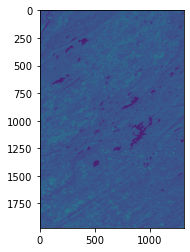

<AxesSubplot:>

In [8]:
'''
Plot the mosiac
'''

# Plot the Near Infrared band of the final year in the mosaic
show((mosaic[220, :, :]), cmap='viridis')

In [12]:
%%timeit
'''
Extract chips
'''

# Get the coordinate x and y coorindates as arrays
xs = np.array([c[0] for c in coords])
ys = np.array([c[1] for c in coords])

# Get the pixel index (row_i, col(i)) using rasterio
rows, cols = rio.transform.rowcol(xform, xs, ys, op=math.floor)

# Create container for raster chips extracts (one set per feature)
chips = []

# Loop through the coordinates
for i in range(len(rows)):

    # Loop through the observation years
    for year in range(obs_years):

        # Get the start and end band indices for the year
        start = year * bands_per_year
        end = start + bands_per_year

        # Clip the chip window from the corresponding raster tile
        r_clip = mosaic[start : end, (rows[i]-chip_size) : (rows[i]+chip_size+1), (cols[i]-chip_size) : (cols[i]+chip_size+1)]
        
        # Append
        chips.append(r_clip)

29.1 ms ± 721 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<AxesSubplot:title={'center':'LS_SWIR2'}>

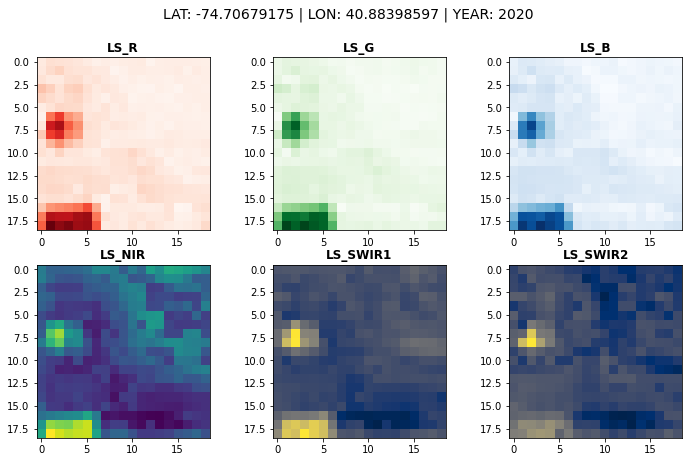

In [10]:
'''
Plot the chip for a given location and year
'''

# Get the observation years as list
years = [y for y in range(1984, 1984 + obs_years)]

# Set the labels of the bands
bands_labels = ['LS_R', 'LS_G', 'LS_B', 'LS_NIR', 'LS_SWIR1', 'LS_SWIR2']

# Set the chip indexer
coord_i, year_i = 200, 36
idx = coord_i * obs_years + year_i

# Create the chip plot
chip_plt, ((r, g, b), (nir, swir1, swir2)) = pyplot.subplots(2, 3, figsize=(12,7))

# Set the tile of the plot to be the geographic location and year
chip_plt.suptitle(f'LAT: {coords[coord_i][0]:.8f} | LON: {coords[coord_i][1]:.8f} | YEAR: {years[year_i]}', fontsize=14)

# Populate the plot facets with the chip bands
show((chips[idx][0, :, :]), ax=r, cmap='Reds', title='LS_R')
show((chips[idx][1, :, :]), ax=g, cmap='Greens', title='LS_G')
show((chips[idx][2, :, :]), ax=b, cmap='Blues', title='LS_B')
show((chips[idx][3, :, :]), ax=nir, cmap='viridis', title='LS_NIR')
show((chips[idx][4, :, :]), ax=swir1, cmap='cividis', title='LS_SWIR1')
show((chips[idx][5, :, :]), ax=swir2, cmap='cividis', title='LS_SWIR2')


In [11]:
'''
Load the chips as a pytorch datasetr
'''

# Load the chips data into a pytorch compatiable dataset class
chips_dataset = ChipsDataset(chips, [Point(*coord).wkt for coord in coords])

# Batch load a portion of the dataset
chips_generator = DataLoader(chips_dataset, batch_size=64)

# Inspect the batch data
batch_data, batch_labels = next(iter(chips_generator))
print(f"Data batch shape: {batch_data.shape}")
print(f"Labels batch shape: {len(batch_labels)}")

Data batch shape: torch.Size([64, 6, 19, 19])
Labels batch shape: 64
